In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation for X-Grad Boost

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv'
df = pd.read_csv(file_path)

In [3]:
df.to_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv', index=False)

In [4]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','neutral_score','day_of_week',]
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

In [6]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)


In [7]:
# Define features and target variable
features = ['rating', 'sentiment_c', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
            'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE', 'product']
target = 'helpful'

In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['rating', 'sentiment_c', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
                      'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE']

# Convert 'product' column to categorical type
df['product'] = df['product'].astype('category')

# Prepare  X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),  # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features
cat_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine column names for the transformed features
all_column_names = np.concatenate([cat_column_names, numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

# 1. Basic X-Grad Boost Model

In [9]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [10]:
from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['product'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=4)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (13725, 18)
X_test shape: (4576, 18)
y_train shape: (13725,)
y_test shape: (4576,)
Train stratify distribution:
 helpful
0    0.839563
1    0.160437
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839161
1    0.160839
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify distribution:
 helpful
0    0.839502
1    0.160498
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839344
1    0.160656
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify distribution:
 helpful
0    0.839356
1    0.160644
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839781
1    0.160219
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify di

In [11]:
# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='lbfgs', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.8563934426229508
F1 Score: 0.3602726387536514
AUC: 0.6119629595210716
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      3841
         1.0       0.63      0.25      0.36       734

    accuracy                           0.86      4575
   macro avg       0.75      0.61      0.64      4575
weighted avg       0.83      0.86      0.83      4575

[[3733  108]
 [ 549  185]]


In [13]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8655737704918033
F1 Score: 0.49382716049382713
AUC: 0.6807981005173636
Confusion Matrix:
[[3660  181]
 [ 434  300]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      3841
         1.0       0.62      0.41      0.49       734

    accuracy                           0.87      4575
   macro avg       0.76      0.68      0.71      4575
weighted avg       0.85      0.87      0.85      4575

Mean Cross-Validated Accuracy: 0.8140860493222796


## 1.2 Feature Importance with Shap Values

[09:55:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


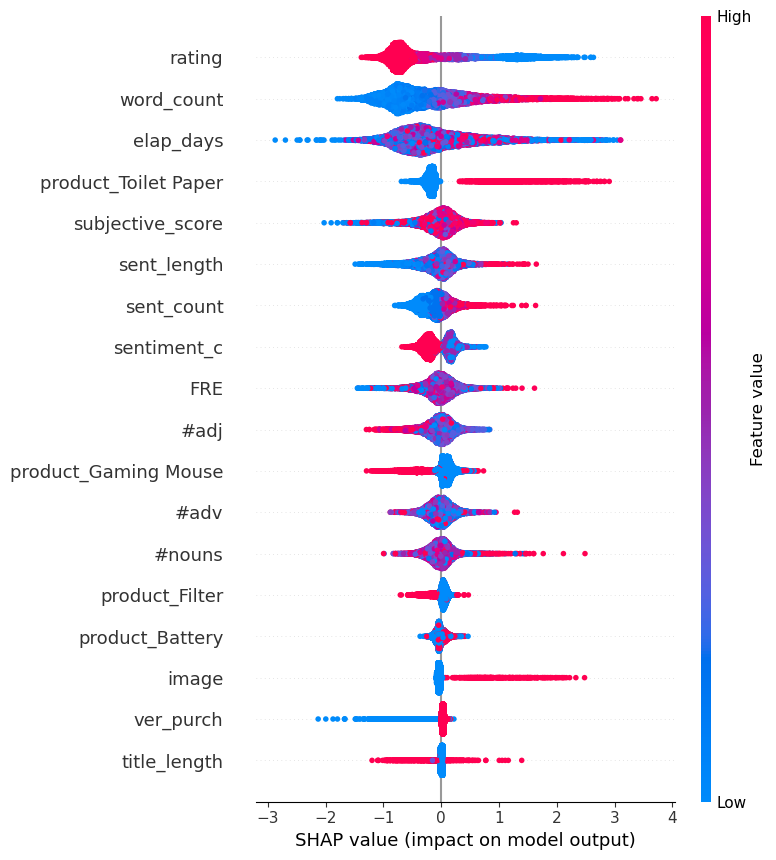

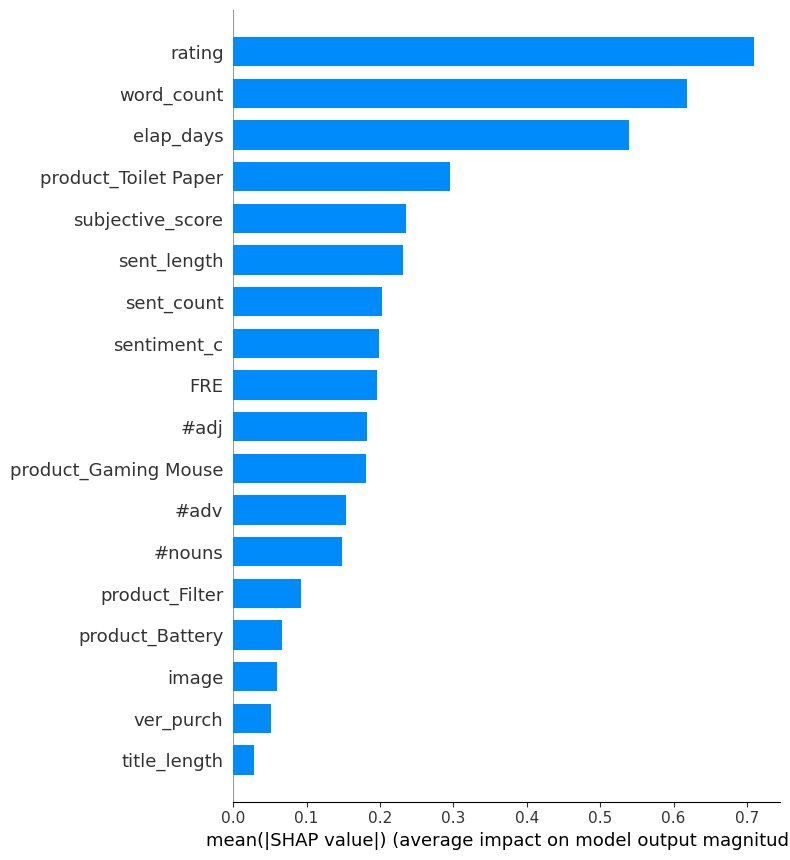

In [14]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.show()

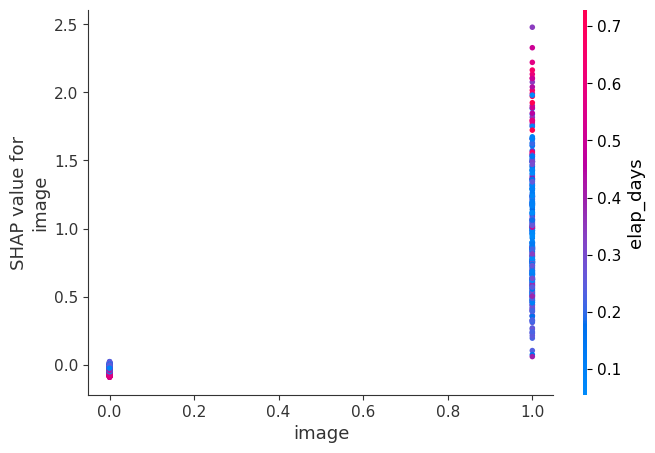

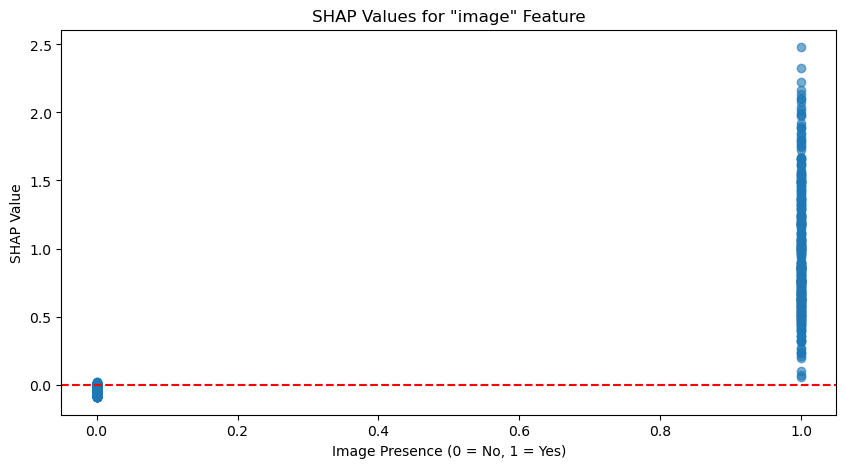

In [15]:
# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, X_train)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [16]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)


In [17]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
4                 rating            0.709643
6             word_count            0.617954
10             elap_days            0.538949
3   product_Toilet Paper            0.295676
16      subjective_score            0.234853
8            sent_length            0.231558
7             sent_count            0.202910
5            sentiment_c            0.198679
17                   FRE            0.195646
14                  #adj            0.182773
2   product_Gaming Mouse            0.180847
15                  #adv            0.154328
13                #nouns            0.147949
1         product_Filter            0.092068
0        product_Battery            0.066342
11                 image            0.059257
12             ver_purch            0.051549
9           title_length            0.028721


# 2. Applying SMOTE for Imbalanced Dataset

In [18]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())



Class distribution after SMOTE:
0.0    11522
1.0     8000
Name: count, dtype: int64


In [19]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_default = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.8493989071038252
F1 Score: 0.5018076644974693
AUC: 0.6970633428085187
Confusion Matrix:
[[3539  302]
 [ 387  347]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3841
         1.0       0.53      0.47      0.50       734

    accuracy                           0.85      4575
   macro avg       0.72      0.70      0.71      4575
weighted avg       0.84      0.85      0.85      4575

Mean Cross-Validated Accuracy: 0.7950101671879264


In [20]:
# With considering inbalanced data
from collections import Counter
sqrt = np.sqrt

# Assuming y_train is your ndarray
counts = Counter(y_train.flatten())

# counts[0] will give you the count of 0s
# counts[1] will give you the count of 1s
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = sqrt(count_of_zeros /count_of_ones)

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: Counter({0.0: 11522, 1.0: 2204})
scale_pos_weight: 2.28643121372584


# 3. Hyperparameter tuning

In [21]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [22]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8083060109289617                                     
  1%|          | 1/100 [00:00<00:16,  5.97trial/s, best loss: -0.8083060109289617]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7971584699453552                                                                
SCORE:                                                                            
0.8087431693989071                                                                
  3%|▎         | 3/100 [00:00<00:15,  6.40trial/s, best loss: -0.8087431693989071]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8089617486338798                                                                
  4%|▍         | 4/100 [00:00<00:15,  6.20trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8059016393442623                                                                
SCORE:                                                                            
0.7975956284153005                                                                
  6%|▌         | 6/100 [00:01<00:16,  5.87trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7986885245901639                                                                
SCORE:                                                                            
0.8083060109289617                                                                
  8%|▊         | 8/100 [00:01<00:13,  6.67trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.805464480874317                                                                 
SCORE:                                                                            
0.7973770491803279                                                                
 10%|█         | 10/100 [00:01<00:13,  6.75trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7975956284153005                                                                 
SCORE:                                                                             
0.8069945355191257                                                                 
 12%|█▏        | 12/100 [00:01<00:12,  6.81trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8078688524590164                                                                 
SCORE:                                                                             
0.8045901639344263                                                                 
 14%|█▍        | 14/100 [00:02<00:12,  6.77trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8048087431693989                                                                 
SCORE:                                                                             
0.8008743169398908                                                                 
 16%|█▌        | 16/100 [00:02<00:12,  6.68trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7940983606557377                                                                 
SCORE:                                                                             
0.8085245901639344                                                                 
 18%|█▊        | 18/100 [00:02<00:11,  7.21trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8039344262295082                                                                 
SCORE:                                                                             
0.8032786885245902                                                                 
 20%|██        | 20/100 [00:03<00:12,  6.52trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8083060109289617                                                                 
SCORE:                                                                             
0.8021857923497268                                                                 
 22%|██▏       | 22/100 [00:03<00:11,  6.76trial/s, best loss: -0.8089617486338798]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8100546448087431                                                                 
SCORE:                                                                             
0.8069945355191257                                                                 
 24%|██▍       | 24/100 [00:03<00:11,  6.42trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7971584699453552                                                                 
SCORE:                                                                             
0.8052459016393443                                                                 
 26%|██▌       | 26/100 [00:04<00:12,  5.70trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8065573770491803                                                                 
 27%|██▋       | 27/100 [00:04<00:12,  5.94trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.793879781420765                                                                  
SCORE:                                                                             
0.8093989071038251                                                                 
 29%|██▉       | 29/100 [00:04<00:11,  6.45trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8089617486338798                                                                 
SCORE:                                                                             
0.8083060109289617                                                                 
 31%|███       | 31/100 [00:04<00:11,  6.10trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7993442622950819                                                                 
SCORE:                                                                             
0.8076502732240437                                                                 
 33%|███▎      | 33/100 [00:05<00:11,  6.08trial/s, best loss: -0.8100546448087431]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8104918032786885                                                                 
SCORE:                                                                             
0.8076502732240437                                                                 
 35%|███▌      | 35/100 [00:05<00:10,  6.38trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8050273224043716                                                                 
SCORE:                                                                             
0.8083060109289617                                                                 
 37%|███▋      | 37/100 [00:05<00:10,  5.90trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8072131147540984                                                                 
SCORE:                                                                             
0.8056830601092896                                                                 
 39%|███▉      | 39/100 [00:06<00:10,  5.95trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7945355191256831                                                                 
SCORE:                                                                             
0.8050273224043716                                                                 
 41%|████      | 41/100 [00:06<00:09,  6.29trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8039344262295082                                                                 
SCORE:                                                                             
0.8056830601092896                                                                 
 43%|████▎     | 43/100 [00:06<00:09,  5.84trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8063387978142077                                                                 
 44%|████▍     | 44/100 [00:06<00:08,  6.33trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8041530054644809                                                                 
SCORE:                                                                             
0.7986885245901639                                                                 
 46%|████▌     | 46/100 [00:07<00:08,  6.60trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8083060109289617                                                                 
SCORE:                                                                             
0.801311475409836                                                                  
 48%|████▊     | 48/100 [00:07<00:07,  6.69trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8089617486338798                                                                 
SCORE:                                                                             
0.7973770491803279                                                                 
 50%|█████     | 50/100 [00:07<00:08,  6.15trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7989071038251366                                                                 
 51%|█████     | 51/100 [00:08<00:08,  5.68trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8048087431693989                                                                 
SCORE:                                                                             
0.7986885245901639                                                                 
 53%|█████▎    | 53/100 [00:08<00:09,  4.99trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.806775956284153                                                                  
SCORE:                                                                             
0.8072131147540984                                                                 
 55%|█████▌    | 55/100 [00:08<00:08,  5.32trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7986885245901639                                                                 
SCORE:                                                                             
0.8076502732240437                                                                 
 57%|█████▋    | 57/100 [00:09<00:07,  5.95trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8076502732240437                                                                 
SCORE:                                                                             
0.8059016393442623                                                                 
 59%|█████▉    | 59/100 [00:09<00:06,  6.28trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8093989071038251                                                                 
SCORE:                                                                             
0.8017486338797815                                                                 
 61%|██████    | 61/100 [00:09<00:06,  6.00trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7991256830601093                                                                 
SCORE:                                                                             
0.8032786885245902                                                                 
 63%|██████▎   | 63/100 [00:10<00:06,  6.10trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8065573770491803                                                                 
SCORE:                                                                             
0.8052459016393443                                                                 
 65%|██████▌   | 65/100 [00:10<00:05,  6.14trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8083060109289617                                                                 
SCORE:                                                                             
0.8072131147540984                                                                 
 67%|██████▋   | 67/100 [00:10<00:07,  4.69trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8076502732240437                                                                 
SCORE:                                                                             
0.8052459016393443                                                                 
 69%|██████▉   | 69/100 [00:11<00:05,  5.63trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8080874316939891                                                                 
SCORE:                                                                             
0.8085245901639344                                                                 
 71%|███████   | 71/100 [00:11<00:04,  6.42trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8085245901639344                                                                 
SCORE:                                                                             
0.8083060109289617                                                                 
 73%|███████▎  | 73/100 [00:11<00:04,  6.44trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8083060109289617                                                                 
SCORE:                                                                             
0.8087431693989071                                                                 
 75%|███████▌  | 75/100 [00:12<00:03,  6.98trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.806775956284153                                                                  
SCORE:                                                                             
0.8037158469945355                                                                 
 77%|███████▋  | 77/100 [00:12<00:03,  7.03trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8089617486338798                                                                 
SCORE:                                                                             
0.7973770491803279                                                                 
 79%|███████▉  | 79/100 [00:12<00:03,  6.64trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8059016393442623                                                                 
SCORE:                                                                             
0.8069945355191257                                                                 
 81%|████████  | 81/100 [00:13<00:03,  6.15trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7991256830601093                                                                 
SCORE:                                                                             
0.8078688524590164                                                                 
 83%|████████▎ | 83/100 [00:13<00:02,  5.94trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8072131147540984                                                                 
SCORE:                                                                             
0.807431693989071                                                                  
 85%|████████▌ | 85/100 [00:13<00:02,  6.36trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8072131147540984                                                                 
SCORE:                                                                             
0.8065573770491803                                                                 
 87%|████████▋ | 87/100 [00:14<00:02,  6.16trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8024043715846995                                                                 
SCORE:                                                                             
0.8089617486338798                                                                 
 89%|████████▉ | 89/100 [00:14<00:01,  6.45trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7993442622950819                                                                 
SCORE:                                                                             
0.7969398907103825                                                                 
 91%|█████████ | 91/100 [00:14<00:01,  6.68trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8056830601092896                                                                 
SCORE:                                                                             
0.8052459016393443                                                                 
 93%|█████████▎| 93/100 [00:14<00:01,  6.61trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.806120218579235                                                                  
SCORE:                                                                             
0.8069945355191257                                                                 
 95%|█████████▌| 95/100 [00:15<00:00,  6.45trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8021857923497268                                                                 
SCORE:                                                                             
0.8026229508196722                                                                 
 97%|█████████▋| 97/100 [00:15<00:00,  6.30trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8089617486338798                                                                 
SCORE:                                                                             
0.8030601092896175                                                                 
 99%|█████████▉| 99/100 [00:15<00:00,  6.54trial/s, best loss: -0.8104918032786885]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7958469945355191                                                                 
100%|██████████| 100/100 [00:16<00:00,  6.23trial/s, best loss: -0.8104918032786885]
The best hyperparameters are :  

{'colsample_bytree': 0.7886970724884891, 'gamma': 4.796023251656782, 'max_depth': 10.0, 'min_child_weight': 6.0, 'reg_alpha': 41.0, 'reg_lambda': 0.2608503158464851}


In [29]:
best_hyperparams={'colsample_bytree': 0.7886970724884891, 'gamma': 4.796023251656782, 'max_depth': 10, 'min_child_weight': 6.0, 'reg_alpha': 41.0, 'reg_lambda': 0.2608503158464851}



In [31]:
# Train model with default hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train, y_train)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.8493989071038252
F1 Score: 0.5018076644974693
AUC: 0.6970633428085187
Confusion Matrix:
[[3539  302]
 [ 387  347]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3841
         1.0       0.53      0.47      0.50       734

    accuracy                           0.85      4575
   macro avg       0.72      0.70      0.71      4575
weighted avg       0.84      0.85      0.85      4575

Mean Cross-Validated Accuracy: 0.8219478174579485


[09:55:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


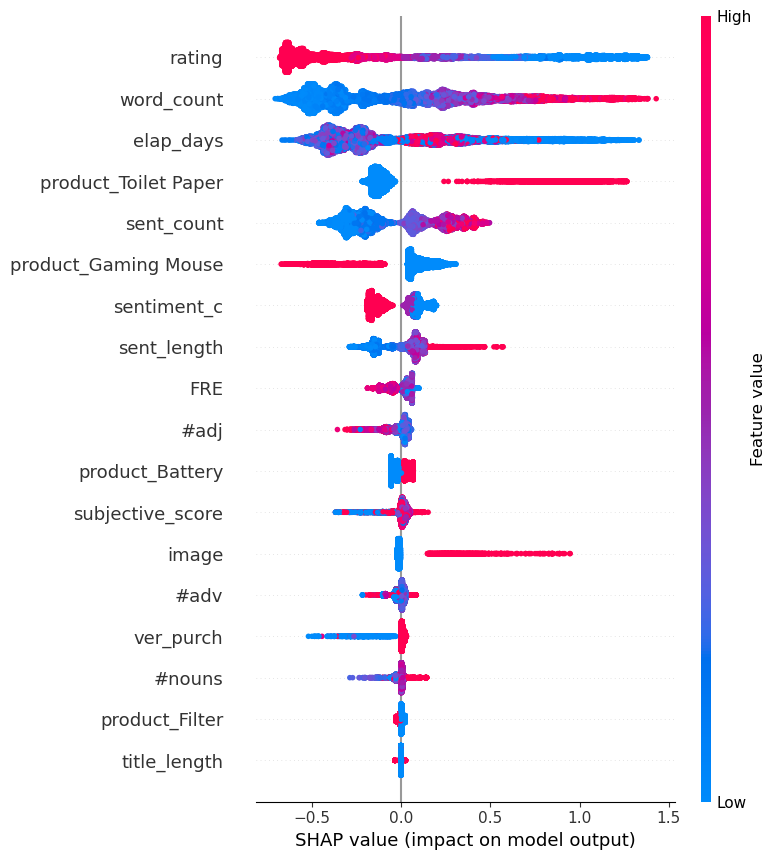

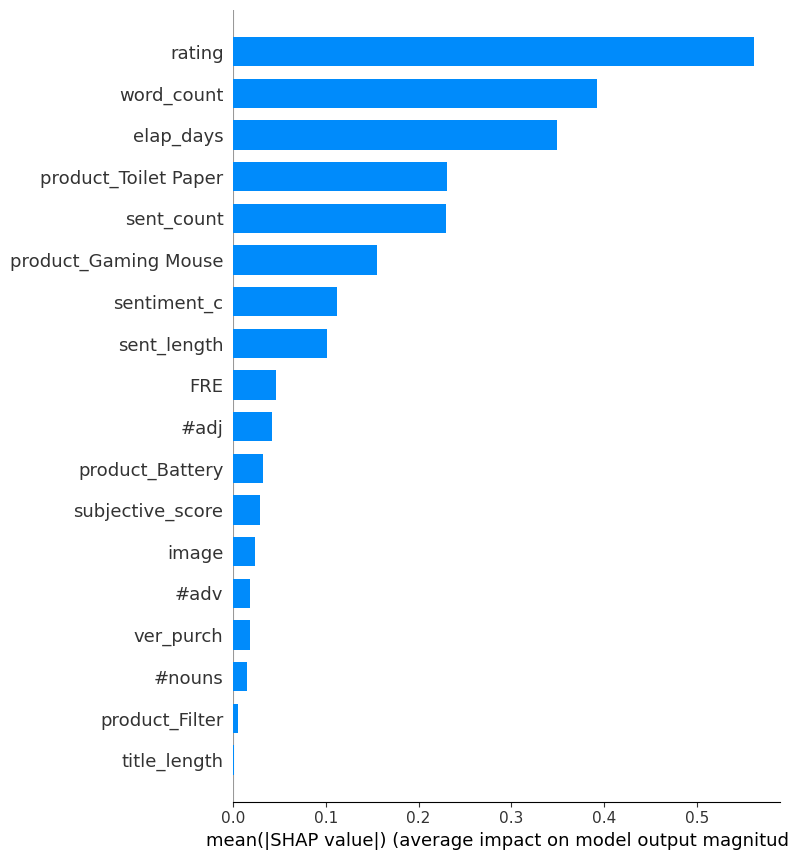

In [25]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_balanced)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=False)
plt.show()


[09:55:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


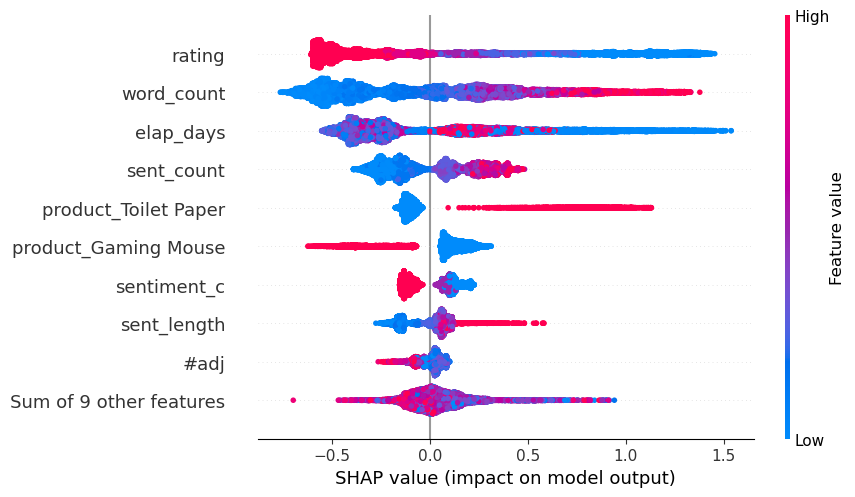

In [26]:
# compute SHAP values
explainer = shap.Explainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)


[09:55:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


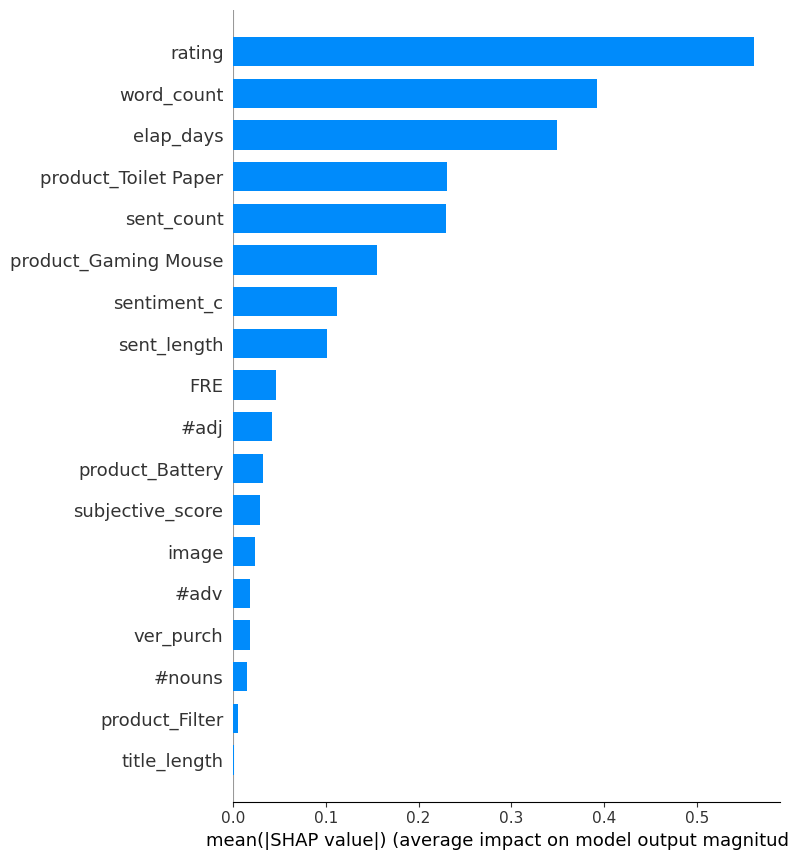

In [27]:
import matplotlib.pyplot as plt
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True)


[09:55:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


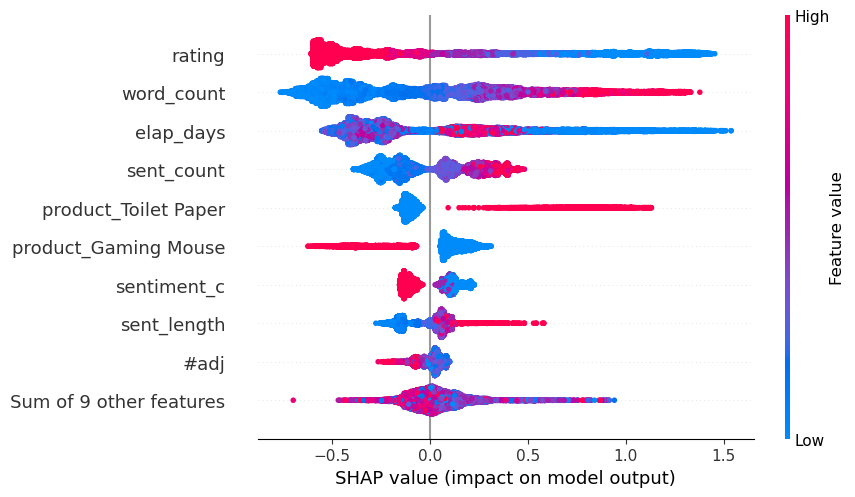

In [28]:
# compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)